# AIP Local Descriptors - Joseph Twal TL97UA

* the code is implemented on virtual enviroment python 3.8.7 opencv 4.5.2 numpy 1.20.
* Building a dataset from a video and train these images to detecte faces from a video.
* extracting each frame from a video to get images.
* for the purpose of this project i did not train all the frames, i only took 10 frame of each person and the reason for that is because i have a lot of frames and my pc start to crash when i train all of the frames.
* there is a script at the end to detect faces from short video of both of them and sometime the detection fails due to not enough samples being trained but i trained and test all of the frames i will be able to get better result.
* I hope you will enjoy my work :) 

In [1]:
# import all libraries to be used
import numpy as np
import cv2
import os
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

# Building the dataset from video 

In [ ]:
# Read the video from specified path
cam = cv2.VideoCapture("./video/2.mp4")

In [ ]:
# For extracting the images from the video to build dataset 
try:
      
    # creating a folder named data
    if not os.path.exists('data2'):
        os.makedirs('data2')
  
# if not created then raise error
except OSError:
    print ('Error: Creating directory of data')
  
# frame
currentframe = 0
  
while(True):
      
    # reading from frame
    ret,frame = cam.read()
  
    if ret:
        # if video is still left continue creating images
        name = './data2/frame' + str(currentframe) + '.jpg'
        print ('Creating..' + name)
  
        # writing the extracted images
        cv2.imwrite(name, frame)
  
        # increasing counter so that it will
        # show how many frames are created
        currentframe += 1
    else:
        break
  
# Release all space and windows once done
cam.release()
cv2.destroyAllWindows()

# Face Detection and recognition Code

In [2]:
haarcascade_model = './haarcascade_frontalface_default.xml'

# creat an instance of the the HAAR classifier
haar_cascade_face_model = cv2.CascadeClassifier(haarcascade_model)

In [3]:
# Function to retieve pictures for training
def get_images(folder_path, ext='jpg', size=(1080,1080)):
    faces = [cv2.imread(str(im), cv2.IMREAD_GRAYSCALE) for im in Path(folder_path).rglob('*.' + ext)]
    faces_sized = []
    for i, img  in enumerate(faces):
        width = size[0]
        height = size[1]
        dim = (width, height)
        
        # resize image
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        faces_sized.append(resized)
    return faces_sized

In [4]:
# Get jimmy's face
jimmy_faces = get_images('./jj/')
# convert it into a Numpy array.
x = np.array(jimmy_faces)
x.shape

(10, 1080, 1080)

In [5]:
# Get john's face
john_faces = get_images('./jo/')
# convert it into a Numpy array.
x2 = np.array(john_faces)
x2.shape

(10, 1080, 1080)

In [6]:
# Now we prepare train_data from both data
x_all = np.append(x,x2)
x_train = x_all.reshape(-1,(1080**2)).astype(np.float32)
x_train.shape

(20, 1166400)

In [7]:
# Create labels for train data
labels  = enumerate(['jimmy', 'john'])
k = [x for x,y in labels]
jimmy_labels = np.repeat(k[0],x.shape[0]) #labels for jimmy
john_labels = np.repeat(k[1],x2.shape[0]) #labels for john
x_train_labels = np.append(jimmy_labels, john_labels)[:,np.newaxis]
x_train_labels.shape

(20, 1)

In [8]:
# Create test data
mixed_faces = get_images('./jjj/')
# convert it into a Numpy array.
test_data = np.array(mixed_faces).reshape(-1,(1080**2)).astype(np.float32)
test_data.shape

(10, 1166400)

In [9]:
len(mixed_faces)

10

In [10]:
# Create label for the test data
jimmy_labels = np.repeat(k[0],(test_data.shape[0]/2)) #labels for Jimmy
john_labels = np.repeat(k[0],(test_data.shape[0]/2)) #labels for john
test_labels = np.append(jimmy_labels, john_labels)[:,np.newaxis]
test_labels.shape

(10, 1)

In [11]:
# Initiate kNN, train the data, then test it with test data for k=1
knn = cv2.ml.KNearest_create()
knn.train(x_train, cv2.ml.ROW_SAMPLE, x_train_labels)

True

In [12]:
# Now we test the KNN model 
ret,result,neighbours,dist = knn.findNearest(test_data,k=12)

In [13]:
# Now we check the accuracy of classification
# For that, compare the result with test_labels and check which are wrong
matches = result==test_labels
correct = np.count_nonzero(matches)
accuracy = correct*100.0/result.size
print(accuracy)

90.0


In [14]:
# save the training data for future use
np.savez('./opencv_knn_data_jimmy_john.npz',train=x_train, train_labels=x_train_labels)
# Now load the data
with np.load('./opencv_knn_data_jimmy_john.npz') as data:
    print( data.files )
    train = data['train']
    train_labels = data['train_labels']

['train', 'train_labels']


In [15]:
# helper function to display image with pyplot
def show_im(image, size=None, title=""):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.title(title)
    plt.axis('off')
    
    if size is not None:
        plt.figure(figsize=size)
    
    plt.imshow(image_rgb)

In [16]:
def locate_faces_in_picture(image, face_classifier, scaleFactor=1.3, minNeighbors=5, thickness=7):
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray_image, scaleFactor, minNeighbors)
    return faces

def get_faces_from_location(image, location_list):

    face_list = []
    widths = [w for (x, y, w, h) in location_list]
    heights = [h for (x, y, w, h) in location_list]
    avg_w = sum(widths)//len(widths)
    avg_h = sum(heights)//len(heights)

    for (x, y, w, h) in location_list:
        im = cv2.cvtColor(image[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)      
        # face_list.append(cv2.resize(im, (avg_h,avg_w), interpolation = cv2.INTER_AREA))
        face_list.append(cv2.resize(im, (1080,1080), interpolation = cv2.INTER_AREA))
    
    return face_list

In [17]:
# load training data
with np.load('./opencv_knn_data_jimmy_john.npz') as data:
    print( data.files )
    train = data['train']
    train_labels = data['train_labels']

# Initiate kNN, train the data, then test it with test data for k=1
knn = cv2.ml.KNearest_create()
knn.train(train, cv2.ml.ROW_SAMPLE, train_labels)

['train', 'train_labels']


True

In [18]:
im3 = cv2.imread('./data2/frame12146.jpg')
face_locations = locate_faces_in_picture(im3, haar_cascade_face_model)
face_lists = get_faces_from_location(im3, face_locations)

In [19]:
face_lists[1].shape

(1080, 1080)

In [20]:

x = face_lists[0].shape[0] * face_lists[0].shape[0]
test_data = np.array(face_lists).reshape(-1,x).astype(np.float32)
test_data.shape

(2, 1166400)

In [21]:
# Now we test the KNN model 
ret,result,neighbours,dist = knn.findNearest(test_data,k=10)
result

array([[1.],
       [0.]], dtype=float32)

In [22]:
labels  = enumerate(['jimmy', 'john'])
lbl = ['jimmy', 'john']

In [23]:
def evaluate_rslt(results, labels):
    lst = []
    for result in results:
        y = lbl[int(result)]
        lst.append(y)
    return lst

In [24]:
face_labels = evaluate_rslt(result, labels)
face_labels

['john', 'jimmy']

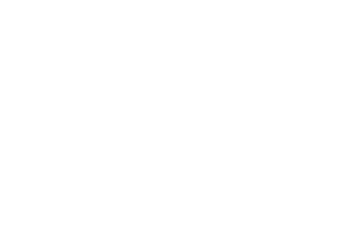

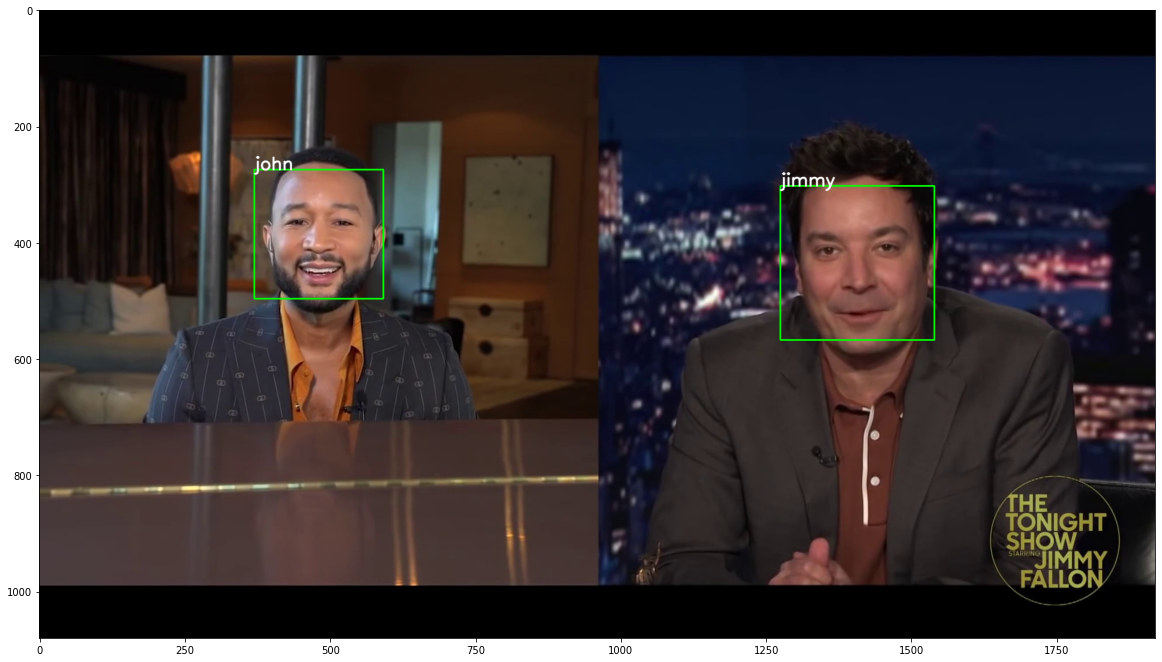

In [25]:
image = im3.copy()
for locs, label in zip(face_locations, face_labels):
        (x, y, w, h) = locs
        thickness = 2
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), thickness)
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 4
        color = (255,255,255,0)
        lineType = cv2.LINE_AA

        cv2.putText(image,label,(x,y), font, 1,color,2,cv2.LINE_AA)

show_im(image, size=(20,20))

# Video detection

In [26]:
# To capture video from existing video.   
cap = cv2.VideoCapture('./video/3.mp4')  
  
while True:  
    # Read the frame  
    _, img = cap.read()  
  
    # Convert to grayscale  
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
  
    # Detect the faces  
    faces = haar_cascade_face_model.detectMultiScale(gray, 1.1, 4)  
  
    # Draw the rectangle around each face  
    for (x, y, w, h), label in zip(faces, face_labels):
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)  
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 4
        color = (255,255,255,0)
        lineType = cv2.LINE_AA
        cv2.putText(img,label,(x,y), font, 1,color,2,cv2.LINE_AA)
  
    # Display  
    cv2.imshow('Video', img)  
  
    # Stop if escape key is pressed  
    k = cv2.waitKey(30) & 0xff  
    if k==27:  
        break  
          
# Release the VideoCapture object  
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.5.2) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-vi271kac\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


# The last error is because i have stopped the video before it finished.